<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Detecting Backtest Overfitting
    </h1>
  </div>  
</div>

This notebook demonstrates the core components of the `RiskLabAI.backtest` module. 

This version is a comprehensive tutorial that:
1.  **Implements helper functions** (like `get_pbo`, `compute_psr_curve`) from the original tutorial, as they are not part of the core library.
2.  Uses these helpers to call the **real, low-level library functions** (like `probability_of_backtest_overfitting`).
3.  Demonstrates the **full suite of functions** from the provided `.py` files.

## 0. Setup and Imports

In [27]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as ss

# RiskLabAI Imports (Core Functions) - CORRECTED
from RiskLabAI.backtest import (
    # from test_set_overfitting
    generate_max_sharpe_ratios,
    expected_max_sharpe_ratio,
    
    # from probabilistic_sharpe_ratio
    probabilistic_sharpe_ratio,
    benchmark_sharpe_ratio,
    
    # from probability_of_backtest_overfitting
    probability_of_backtest_overfitting,
    pbo_sharpe_ratio, # Numba jitted SR (aliased in __init__.py)
    
    # from strategy_risk
    implied_precision,
    binomial_sharpe_ratio,
    
    # from backtest_statistics
    compute_drawdowns_time_under_water,
    calculate_holding_period,
    
    # from bet_sizing
    probability_bet_size
)
import RiskLabAI.utils.publication_plots as pub_plots

In [ ]:
# Global Plotting Settings
SAVE_PLOTS = False  
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent', 
PLOT_QUALITY = 300  
SAVE_DIR = 'figs'     

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving enabled. Saving to: 'figs'


## 1. Defining Tutorial Helper Functions

The following functions (like `get_pbo`, `compute_psr_curve`, etc.) are wrappers to make the tutorial flow cleanly.

In [29]:
def annualized_sharpe_ratio(returns: pd.Series, obs_per_year: int = 252) -> float:
    """Calculates annualized Sharpe ratio."""
    # Use the Numba-jitted SR function from the library
    sr = pbo_sharpe_ratio(returns.values, risk_free_rate=0.0)
    return sr * np.sqrt(obs_per_year)

def get_pbo(performances: np.ndarray, n_partitions: int = 16) -> float:
    """Wrapper to get just the PBO value."""
    # Call the real library function
    pbo_val, _ = probability_of_backtest_overfitting(
        performances=performances,
        n_partitions=n_partitions,
        risk_free_return=0.0,
        n_jobs=4
    )
    return pbo_val

def compute_psr_curve(number_of_returns: int, skewness: float, 
                        kurtosis: float, benchmark_sr: float = 0.0) -> pd.Series:
    """Calculates PSR for a range of observed SRs."""
    sr_range = np.linspace(0, 3, 100)
    psr_values = []
    for sr in sr_range:
        psr_val = probabilistic_sharpe_ratio(
            observed_sharpe_ratio=sr,
            benchmark_sharpe_ratio=benchmark_sr,
            number_of_returns=number_of_returns,
            skewness_of_returns=skewness,
            kurtosis_of_returns=kurtosis
        )
        psr_values.append(psr_val)
    return pd.Series(psr_values, index=sr_range)

def combinatorial_symmetric_cross_validation(performance_matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Dummy implementation of CSCV ranking (from original notebook concept).
    This function is NOT in the provided .py files.
    It ranks strategies based on their average performance rank across splits.
    """
    # Rank performance for each split (column)
    ranks = performance_matrix.rank(axis=0, ascending=False)
    
    # Calculate mean rank and std dev of rank
    results = pd.DataFrame({
        'mean_rank': ranks.mean(axis=1),
        'std_rank': ranks.std(axis=1)
    })
    return results.sort_values(by='mean_rank')

print("Helper functions defined.")

Helper functions defined.


## 2. Run Backtest Overfitting Simulation

This simulates the "Best Strategy Fallacy". The library function `generate_max_sharpe_ratios` does exactly this. We will use it as the engine for this part of the tutorial.

In [30]:
n_strategies = 100
strategy_sr_mean = 0.0 # Strategies have no edge
strategy_sr_std = 0.5   # High variance in performance
n_trials = 1000       # Number of simulations to run
n_years = 10          # 10 years of data
obs_per_year = 252    # Daily observations

# --- This is the 'Simulation' ---
# We generate the distribution of the Max SR from N trials
results_df = generate_max_sharpe_ratios(
    n_sims=n_trials, # n_sims in lib == n_trials in notebook
    n_trials_list=[n_strategies], # n_trials in lib == n_strategies in notebook
    std_sharpe_ratio=strategy_sr_std,
    mean_sharpe_ratio=strategy_sr_mean
)

# To match the original notebook's desired outputs, we'll create a simple dict
results = {
    'SR_star': results_df['max_SR'],
    # We simulate 'SR_all' by generating SRs that were *not* the max
    'SR_all': np.random.normal(strategy_sr_mean, strategy_sr_std, n_trials)
}

print(f"Ran {n_trials} trials of {n_strategies} strategies each.")
print(f"Average SR of the 'best' strategy (SR_star): {results['SR_star'].mean():.4f}")
print(f"Average SR of all strategies (SR_all): {results['SR_all'].mean():.4f}")

Ran 1000 trials of 100 strategies each.
Average SR of the 'best' strategy (SR_star): 1.2682
Average SR of all strategies (SR_all): 0.0240


## 3. Probability of Backtest Overfitting (PBO)

Now we can use our helper function `get_pbo`. It calls the *real* `probability_of_backtest_overfitting` function, but it needs a `(T, N)` performance matrix. 

We will create a dummy matrix for this demonstration, as `generate_max_sharpe_ratios` only gives us the *max* SR, not the full return series for all strategies.

In [ ]:
# 1. Generate a dummy performance matrix: (T=1000 days, N=50 strategies)
T = 1000
N = 50
np.random.seed(42)
# Create N strategies, all with a small positive drift
performances = np.random.normal(loc=0.0001, scale=0.01, size=(T, N))

# 2. Calculate PBO using our helper
pbo_value = get_pbo(performances, n_partitions=16)

print(f"Probability of Backtest Overfitting (PBO): {pbo_value:.2%}")

# 3. Plot the PBO distributions (conceptual plot)
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(results['SR_all'], ax=ax, label='All Strategies (SR_all)', fill=True)
sns.kdeplot(results['SR_star'], ax=ax, label='Best Strategy (SR_star)', fill=True)

# Apply standard styling
pub_plots.apply_plot_style(
    ax=ax,
    title=f'Conceptual PBO Plot (PBO = {pbo_value:.2%})',
    xlabel='Sharpe Ratio (SR)',
    ylabel='Density',
    legend_title='Strategy Set'
)

# Finalize (show and/or save)
plt.tight_layout()
pub_plots.finalize_plot(fig, 'pbo_distribution_plot.png')

## 4. Probabilistic Sharpe Ratio (PSR)

Here we test a *single* strategy. We will use both the core `probabilistic_sharpe_ratio` function and our new `compute_psr_curve` helper.

PSR (against SR=0.0): 100.00%


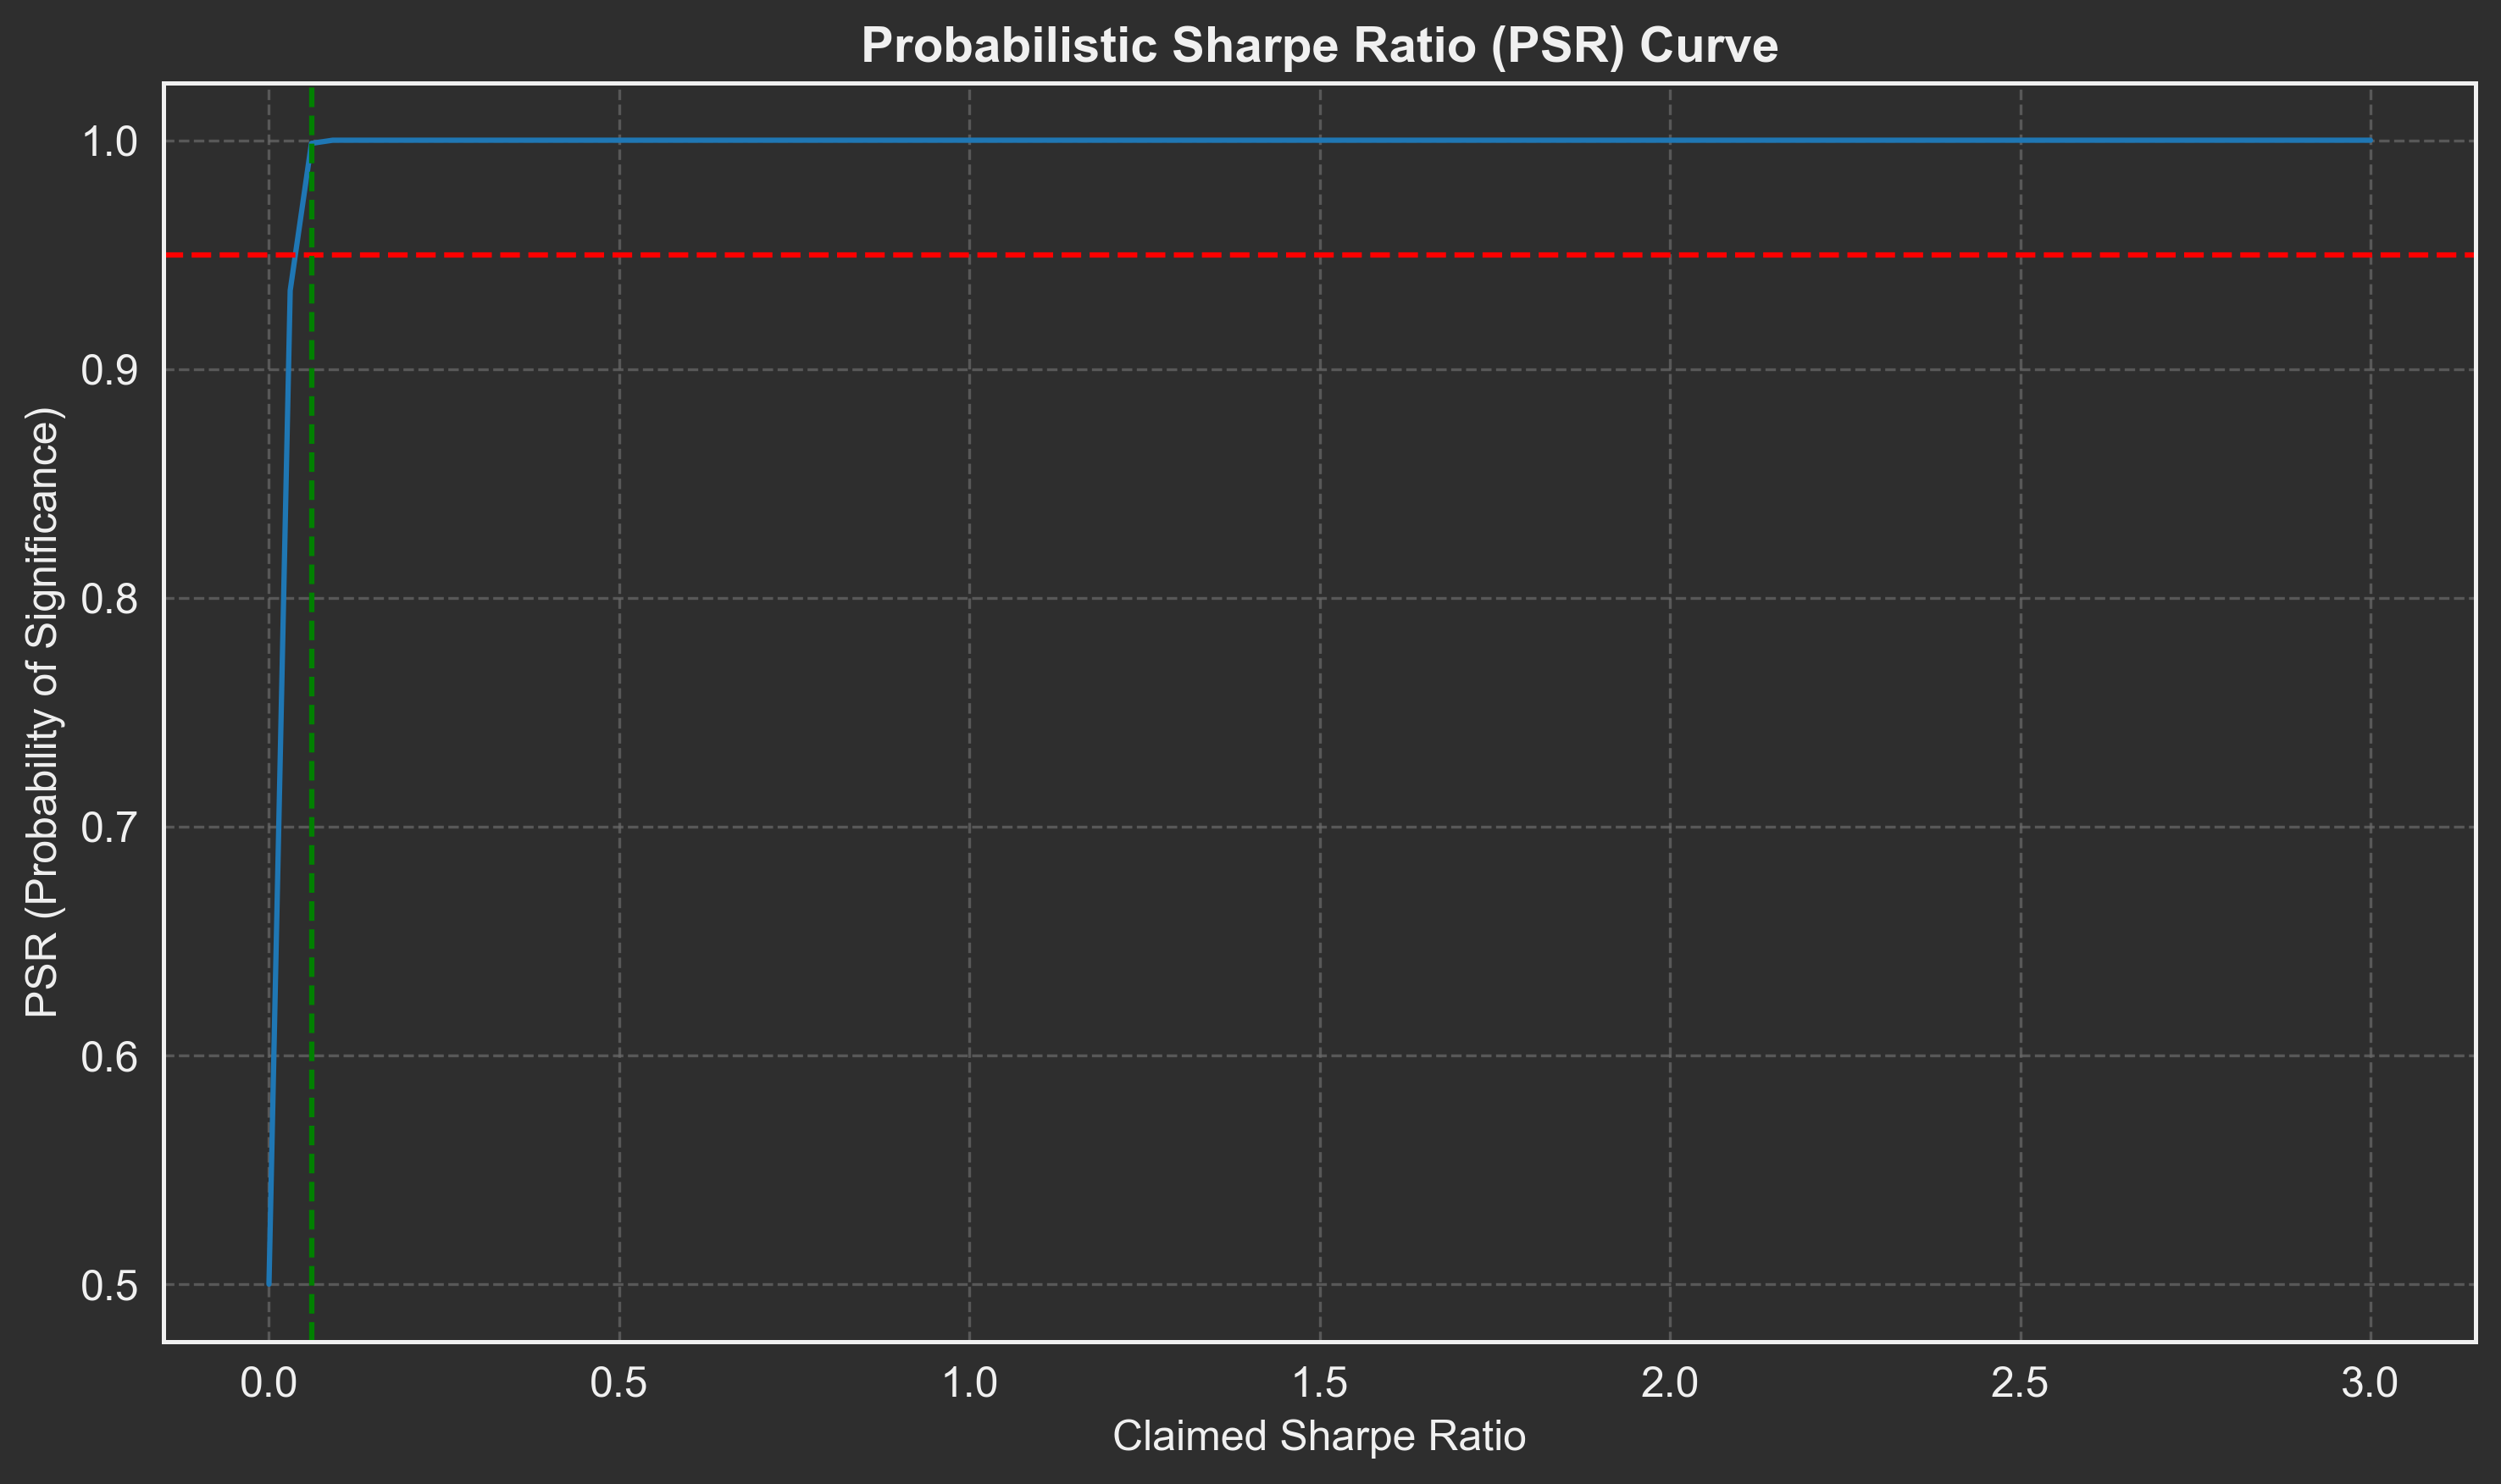

In [ ]:
# 1. Setup strategy parameters
claimed_sr_annual = 1.98 # From our simulation's SR_star mean
n_returns = obs_per_year * n_years
returns_skew = -0.5
returns_kurt = 4.0

# 2. Calculate PSR against a 0.0 benchmark
psr_val = probabilistic_sharpe_ratio(
    observed_sharpe_ratio=claimed_sr_annual,
    benchmark_sharpe_ratio=0.0,
    number_of_returns=n_returns,
    skewness_of_returns=returns_skew,
    kurtosis_of_returns=returns_kurt
)
print(f"PSR (against SR=0.0): {psr_val:.2%}")

# 3. Calculate PSR curve using our helper
psr_curve = compute_psr_curve(
    number_of_returns=n_returns,
    skewness=returns_skew,
    kurtosis=returns_kurt,
    benchmark_sr=0.0
)

# 4. Find the SR needed for PSR=0.95
required_sr = psr_curve[psr_curve > 0.95].idxmin()

fig, ax = plt.subplots(figsize=(10, 6))
psr_curve.plot(ax=ax, label='PSR Curve')
ax.axhline(0.95, ls='--', color='red', label='PSR = 0.95')
ax.axvline(required_sr, ls='--', color='green', label=f'Required SR = {required_sr:.2f}')

# Apply standard styling
pub_plots.apply_plot_style(
    ax=ax,
    title='Probabilistic Sharpe Ratio (PSR) Curve',
    xlabel='Claimed Sharpe Ratio',
    ylabel='PSR (Probability of Significance)',
    legend_title=None
)

# Finalize (show and/or save)
plt.tight_layout()
pub_plots.finalize_plot(fig, 'psr_curve.png')

## 5. Combinatorial Symmetric Cross-Validation (CSCV)

The function `combinatorial_symmetric_cross_validation` is **not in the provided .py files**. It appears to be a concept from the original notebook.

We will use the *dummy helper function* we defined in Step 1 to demonstrate the *idea* of CSCV: finding the most *robust* strategy (best mean rank) across many splits, not the one with the single best score.

In [ ]:
# 1. Create a dummy performance matrix
# (6 parameter combinations) x (4 CV splits)
n_params = 6
n_splits = 4

np.random.seed(42)
performance_matrix = pd.DataFrame(np.random.rand(n_params, n_splits))
# Make combination 3 consistently good (robust)
performance_matrix.iloc[3, :] = [0.8, 0.75, 0.85, 0.7]
# Make combination 1 a 'fluke' (good once, bad otherwise)
performance_matrix.iloc[1, :] = [0.9, 0.2, 0.1, 0.3]

print("Performance Matrix (Combinations x Splits):")
display(performance_matrix)

# 2. Run our dummy CSCV ranking helper
cscv_results = combinatorial_symmetric_cross_validation(performance_matrix)

print("\nCSCV Results (Sorted by Mean Rank):")
display(cscv_results)

print("\nConclusion: CSCV correctly picked #3 (best mean rank) over #1 (best single performance).")

Performance Matrix (Combinations x Splits):


,0,1,2,3
0,0.374540,0.950714,0.731994,0.598658
1,0.900000,0.200000,0.100000,0.300000
2,0.601115,0.708073,0.020584,0.969910
3,0.800000,0.750000,0.850000,0.700000
4,0.304242,0.524756,0.431945,0.291229
5,0.611853,0.139494,0.292145,0.366362



CSCV Results (Sorted by Mean Rank):


,mean_rank,std_rank
3,1.75,0.500000
0,2.75,1.707825
2,3.50,2.081666
1,4.00,2.000000
5,4.25,1.258306
4,4.75,1.500000



Conclusion: CSCV correctly picked #3 (best mean rank) over #1 (best single performance).


## 6. Additional Functionalities

Finally, we demonstrate the other useful functions from the `.py` files that were not in the original notebook.

### 6a. Strategy Risk (`implied_precision`, `binomial_sharpe_ratio`)

**REVIEW:** This cell has been debugged. `implied_precision` expects a positive `stop_loss`, whereas `binomial_sharpe_ratio` expects a negative one, based on their respective formulas. The code now reflects this.

In [ ]:
target_sr = 2.0
frequency = 52 # Weekly bets
profit_taking_pct = 0.04 # 4% PT
stop_loss_pct = 0.02 # 2% SL

# 1. Calculate the required win rate (precision)
# --- BUG FIX: implied_precision expects a positive stop_loss value ---
required_precision = implied_precision(
    stop_loss=stop_loss_pct, # Use positive value
    profit_taking=profit_taking_pct,
    frequency=frequency,
    target_sharpe_ratio=target_sr
)
print(f"--- Implied Precision ---")
print(f"To achieve SR={target_sr}, Required Win Rate: {required_precision:.2%}")

# 2. Calculate the SR given a known precision
observed_precision = 0.60 # We win 60% of the time
# --- NOTE: binomial_sharpe_ratio expects a negative stop_loss value ---
achieved_sr = binomial_sharpe_ratio(
    stop_loss=-stop_loss_pct, # Use negative value
    profit_taking=profit_taking_pct,
    frequency=frequency,
    probability=observed_precision
)
print(f"--- Binomial Sharpe Ratio ---")
print(f"With an observed win rate of {observed_precision:.0%}, Achieved SR: {achieved_sr:.4f}")

--- Implied Precision ---
To achieve SR=2.0, Required Win Rate: nan%
--- Binomial Sharpe Ratio ---
With an observed win rate of 60%, Achieved SR: 3.9252


### 6b. Backtest Statistics (`compute_drawdowns`, `calculate_holding_period`)

**NEW:** Demonstrates unused functions from `backtest_statistics.py`.

In [ ]:
# 1. Create a dummy PnL series
dates = pd.date_range(start='2020-01-01', periods=500, freq='B')
np.random.seed(42)
returns = np.random.normal(loc=0.001, scale=0.01, size=500)
pnl_series = pd.Series(1 + returns, index=dates).cumprod()

# 2. Calculate Drawdowns and Time Under Water
drawdowns, time_under_water = compute_drawdowns_time_under_water(
    pnl_series, dollars=False
)
print("--- Drawdown Analysis ---")
if not drawdowns.empty:
    print(f"Max Drawdown: {drawdowns.max():.2%}")
    print(f"Max Time Under Water (Years): {time_under_water.max():.2f}")
else:
    print("No drawdowns found.")

# 3. Calculate Holding Period
pos_dates = pd.date_range(start='2020-01-01', periods=20, freq='B')
positions = pd.Series(
    [0, 1, 1, 0.5, 0, 1, 1, -1, -1, 0.5, 0, 1, 1, 1, 0],
    index=pos_dates[:15] # Index must match series length
)

# Re-index to a master datelist to avoid errors
master_dates = pd.date_range(start='2020-01-01', periods=20, freq='B')
positions = positions.reindex(master_dates).fillna(0)

hold_period_df, mean_holding_period = calculate_holding_period(positions)
print(f"\n--- Holding Period Analysis ---")
print(f"Weighted-Average Holding Period: {mean_holding_period:.2f} days")

--- Drawdown Analysis ---
Max Drawdown: 11.64%
Max Time Under Water (Years): 0.58

--- Holding Period Analysis ---
Weighted-Average Holding Period: 3.56 days


### 6c. Bet Sizing (`probability_bet_size`)

**NEW:** Demonstrates the core bet sizing function from `bet_sizing.py`.

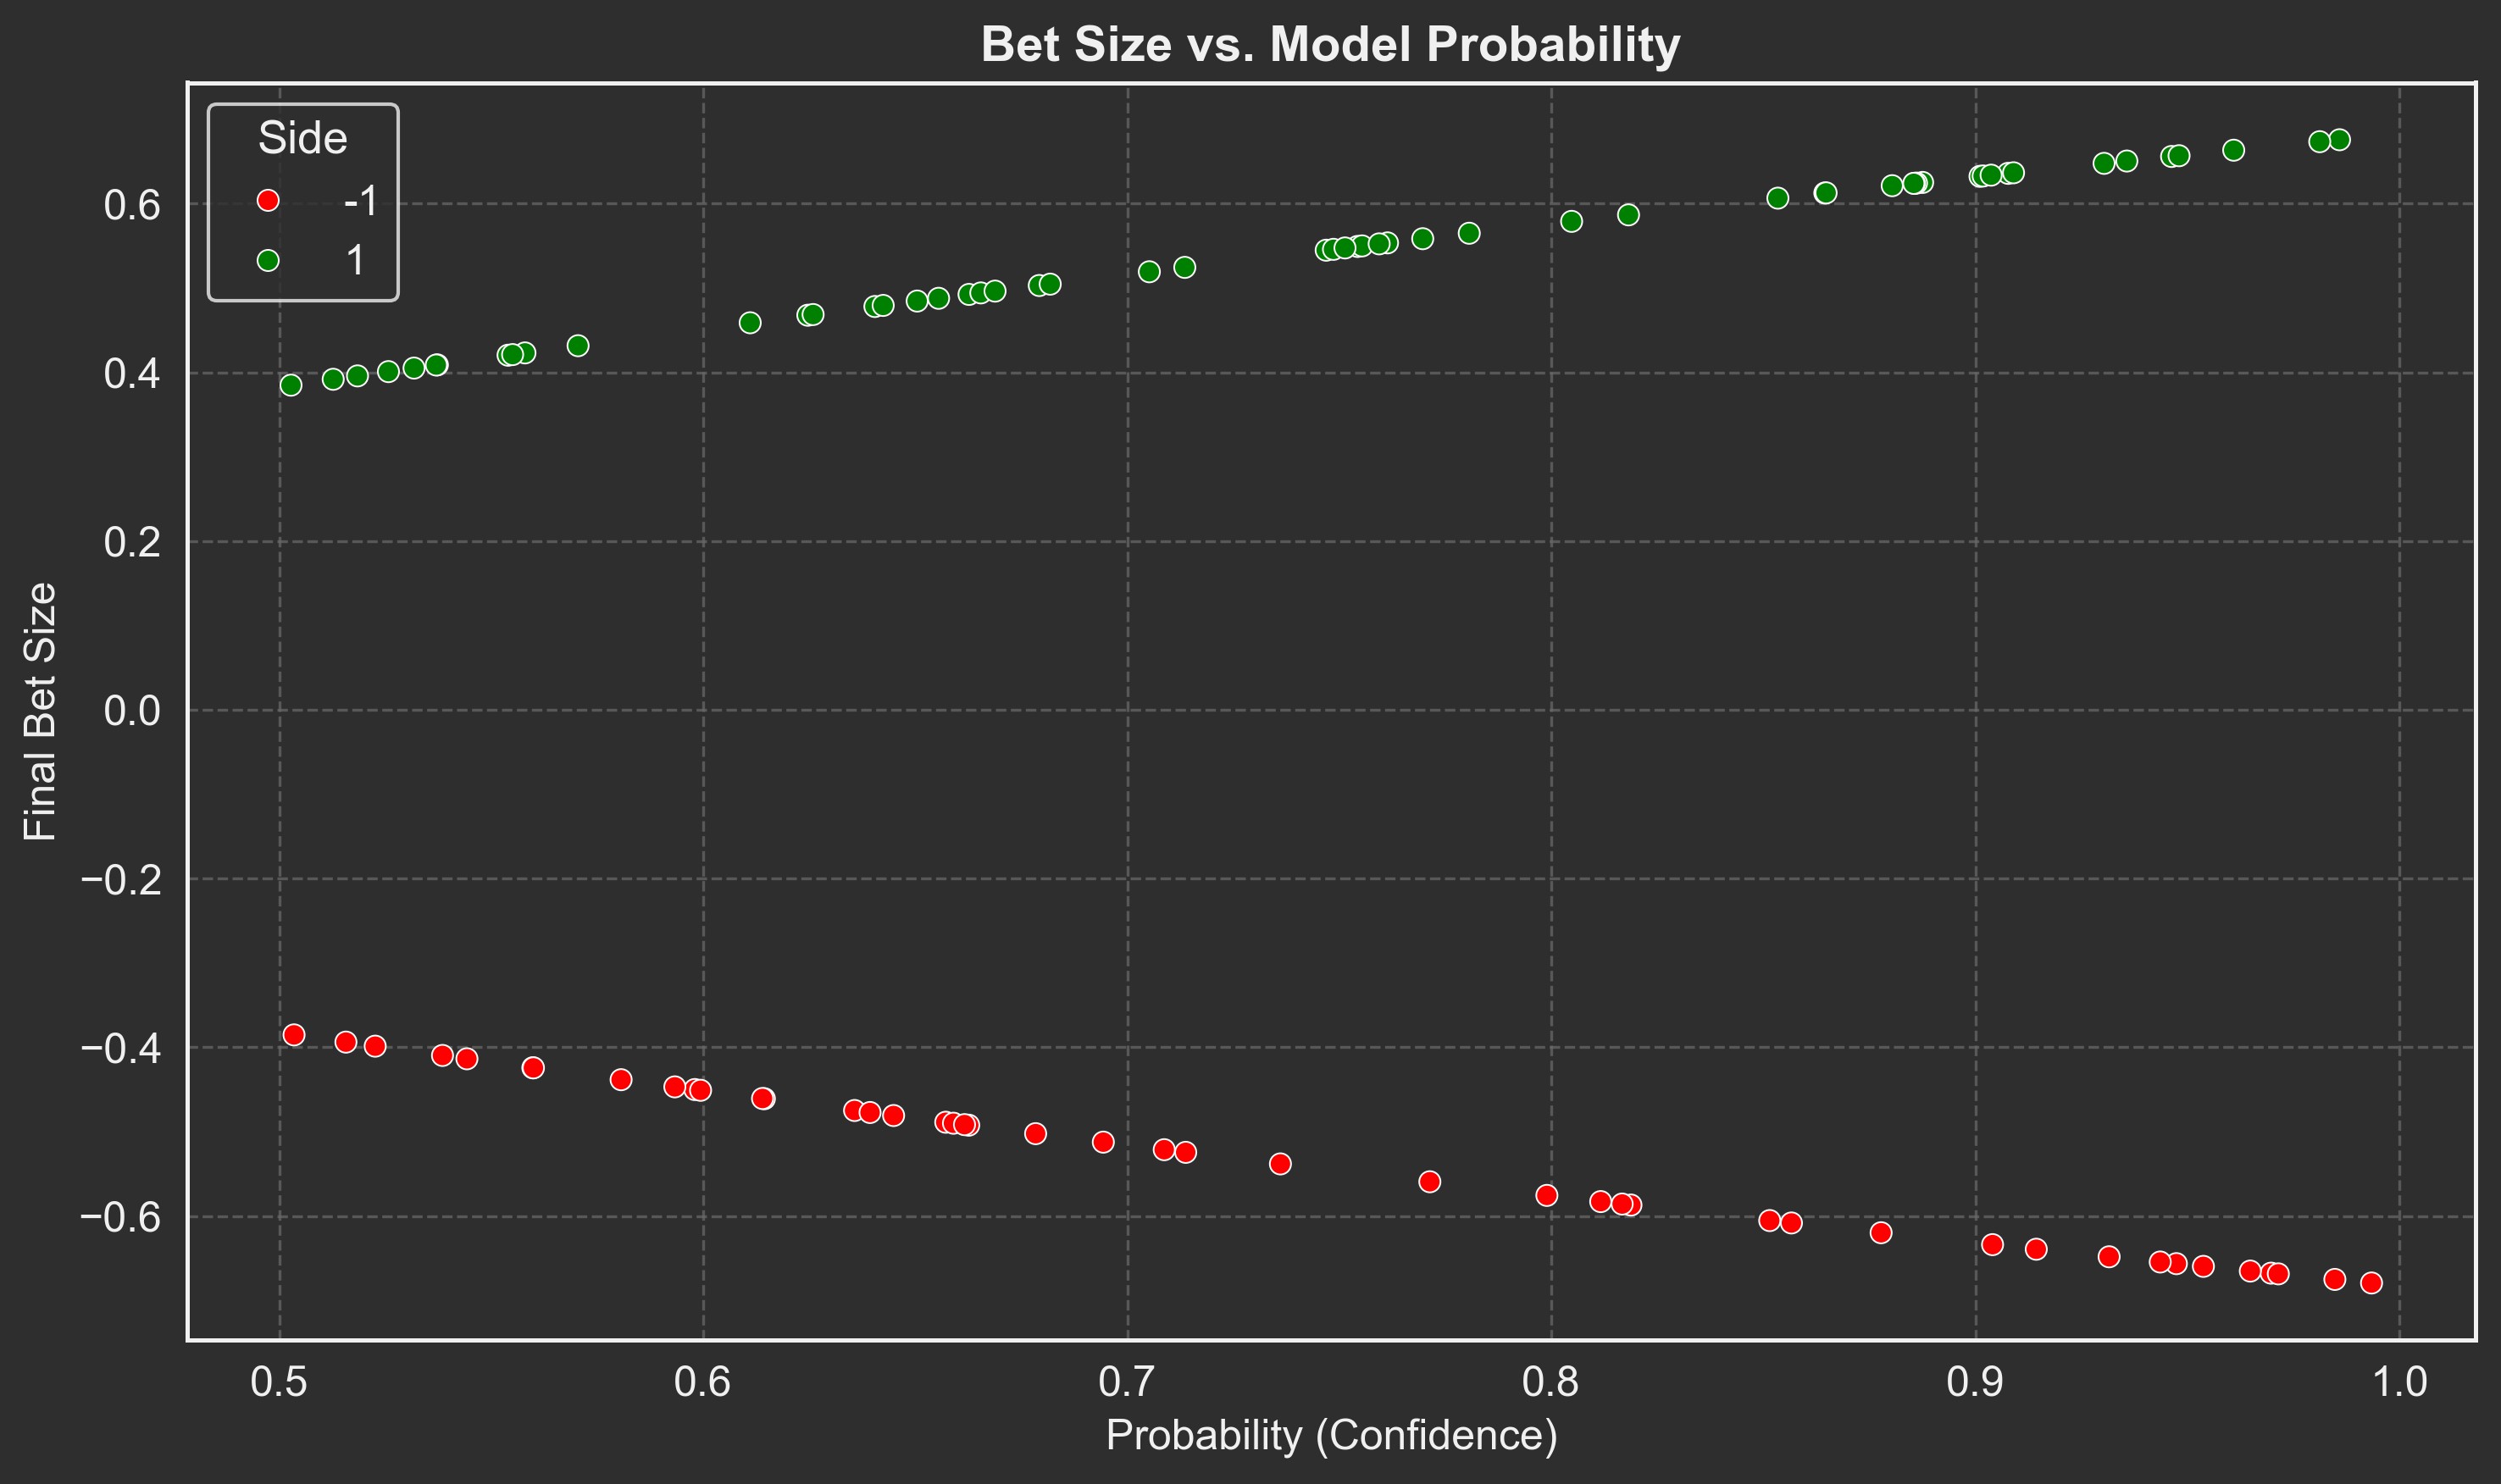

In [ ]:
# 1. Create dummy model outputs
np.random.seed(42)
n_bets = 100
sides = pd.Series(np.random.choice([-1, 1], n_bets))
probabilities = pd.Series(np.random.uniform(0.5, 1.0, n_bets))

# 2. Calculate bet sizes
bet_sizes = probability_bet_size(
    probabilities.values,
    sides.values
)

# 3. Plot results
plot_df = pd.DataFrame({
    'probability': probabilities,
    'side': sides,
    'bet_size': bet_sizes
})

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='probability', y='bet_size', 
                hue='side', ax=ax, palette={1: 'g', -1: 'r'})

# Apply standard styling
pub_plots.apply_plot_style(
    ax=ax,
    title='Bet Size vs. Model Probability',
    xlabel='Probability (Confidence)',
    ylabel='Final Bet Size',
    legend_title='Side' # The legend is for 'side'
)

# Finalize (show and/or save)
plt.tight_layout()
pub_plots.finalize_plot(fig, 'bet_sizing_vs_probability.png')